# Model 1: Modeling Selected Actions

The purpose of this model is to predict the action that the bot will select for a given state of the simulation.

## Preliminary Setup

### Imports

In [1]:
import os
import numpy as np
import random
import math
import json
import pandas as pd
import ast
import datetime
import pickle

In [2]:
# %pip install json

In [3]:
import nbimporter

### Additional Bot Config

In [4]:
import Bot1

In [5]:
file_name = 'Data/Model1/model1_data_raw.csv'

In [6]:
%run Bot1.ipynb

In [7]:
grid, open_cells = create_grid() # Fixed grid orientation

In [8]:
def determine_probabilities(bot, matrix):
    directions = {'up': (bot[0], bot[1] - 1), 
                  'down': (bot[0], bot[1] + 1), 
                  'left': (bot[0] - 1, bot[1]), 
                  'right': (bot[0] + 1, bot[1]),
                  'stay': bot}
    return [matrix.get(directions[direction], 0) for direction in ['up', 'down', 'left', 'right', 'stay']]

In [9]:
def Bot1_collect_data(k, alpha, max_iter, timeout):
    global grid, open_cells
    
    grid, open_cells = reset_grid(grid, open_cells)
    bot, ship, open_cells = place_bot(grid, open_cells)

    crew_list = []
    alien_list = []
    d_lookup_table = {}
    
    data_log = [] # Data Log Initialization

    crew_list, ship = place_crew(ship, open_cells, crew_list)
    alien_list, ship = place_alien(ship, open_cells, alien_list, bot, k)

    alien_matrix = initialize_alienmatrix(open_cells, bot, k)
    crew_matrix = initialize_crewmatrix(open_cells, crew_list, bot)
    
    alien_detected = False
    crew_detected = False
    
    next_move_str = 'stay'

    win_count = 0
    loss_count = 0
    move = 0
    win_move_count = []
    marker = 0

    while (win_count + loss_count) < max_iter:
        neighbors = check_valid_neighbors(len(ship), bot[0], bot[1])
        open_moves = [neigh for neigh in neighbors if (grid[neigh] != 1)]
        open_moves.append(bot) # Bot can stay in place 
        next_move = determine_move(open_moves, alien_matrix, crew_matrix)
        
#         alien_matrix_str_keys = {str(key): round(value, 5) for key, value in alien_matrix.items()}
#         crew_matrix_str_keys = {str(key): round(value, 5) for key, value in crew_matrix.items()}

#         alien_matrix_json = json.dumps(alien_matrix_str_keys)
#         crew_matrix_json = json.dumps(crew_matrix_str_keys)

#         alien_matrix_flat = [round(alien_matrix.get((x, y), 0), 5) for x in range(30) for y in range(30)]
#         crew_matrix_flat = [round(crew_matrix.get((x, y), 0), 5) for x in range(30) for y in range(30)]

        alien_probs = determine_probabilities(bot, alien_matrix)
        crew_probs = determine_probabilities(bot, crew_matrix)
        
        # Convert relative move to string      
        if next_move[0] > bot[0]:
            next_move_str = 'right'
        elif next_move[0] < bot[0]:
            next_move_str = 'left'
        elif next_move[1] > bot[1]:
            next_move_str = 'up'
        elif next_move[1] < bot[1]:
            next_move_str = 'down'
        else:
            next_move_str = 'stay'
        
        # One-Hot Encoding
        actions = {'up': [1, 0, 0, 0, 0], 'down': [0, 1, 0, 0, 0], 'left': [0, 0, 1, 0, 0], 'right': [0, 0, 0, 1, 0], 'stay': [0, 0, 0, 0, 1]}
        best_move_encoded = actions[next_move_str]
        
        log_entry = {
            'bot_x': bot[0],
            'bot_y': bot[1],
            
            'alien_up': alien_probs[0],
            'alien_down': alien_probs[1],
            'alien_left': alien_probs[2],
            'alien_right': alien_probs[3],
            'alien_stay': alien_probs[4],
            
            'crew_up': crew_probs[0],
            'crew_down': crew_probs[1],
            'crew_left': crew_probs[2],
            'crew_right': crew_probs[3],
            'crew_stay': crew_probs[4],
            
            'alien_detected': 1 if alien_detected else 0,
            'crew_detected': 1 if crew_detected else 0,
            
            'chosen_action': best_move_encoded
        }
        data_log.append(log_entry)

#         log_entry = {
#             'bot_x': bot[0],
#             'bot_y': bot[1],
#             **{'alien_' + str(key): value for key, value in alien_matrix.items()},
#             **{'crew_' + str(key): value for key, value in crew_matrix.items()},
#             'alien_detected': 1 if alien_detected else 0,
#             'crew_detected': 1 if crew_detected else 0,
#             'chosen_action': best_move_encoded
#         }
#         data_log.append(log_entry)
        
        prev_win_count = win_count
        bot, crew_list, ship, open_cells, win_count, marker = move_bot(ship, bot, next_move, crew_list, alien_list, open_cells, win_count, 1)
        move += 1

        if marker == 1 or move >= timeout:
            loss_count += 1
            print(f"Bot captured! Win Count: {win_count}, Loss Count: {loss_count}")

            grid, open_cells = reset_grid(grid, open_cells)
            bot, ship, open_cells = place_bot(grid, open_cells)
            crew_list = []
            alien_list = []
            d_lookup_table = {}

            crew_list, ship = place_crew(ship, open_cells, crew_list)
            alien_list, ship = place_alien(ship, open_cells, alien_list, bot, k)

            alien_matrix = initialize_alienmatrix(open_cells, bot, k)
            crew_matrix = initialize_crewmatrix(open_cells, crew_list, bot)
            marker = 0
            move = 0

            continue

        if win_count > prev_win_count:
            print(f"Crew saved! Win Count: {win_count}, Loss Count: {loss_count}")
            win_move_count.append(move)
            move = 0
            d_lookup_table = {}
            alien_matrix = initialize_alienmatrix(open_cells, bot, k)
            crew_matrix = initialize_crewmatrix(open_cells, crew_list, bot)
        
        print(f"Bot: {bot}, Crew: {crew_list}, Aliens: {alien_list}")

        alien_matrix, crew_matrix = update_afterbotmove(bot, alien_matrix, crew_matrix)
        
        marker, alien_list, ship = move_aliens(ship, alien_list, bot) # Move alien randomly

        if marker == 1 or move >= timeout:
            loss_count += 1
            print(f"Bot captured! Win Count: {win_count}, Loss Count: {loss_count}")

            grid, open_cells = reset_grid(grid, open_cells)
            bot, ship, open_cells = place_bot(grid, open_cells)
            crew_list = []
            alien_list = []
            d_lookup_table = {}

            crew_list, ship = place_crew(ship, open_cells, crew_list)
            alien_list, ship = place_alien(ship, open_cells, alien_list, bot, k)

            alien_matrix = initialize_alienmatrix(open_cells, bot, k)
            crew_matrix = initialize_crewmatrix(open_cells, crew_list, bot)
            marker = 0
            move = 0

            continue
        
        alien_matrix = update_afteralienmove(ship, alien_list, alien_matrix) # Update after alien move
        
        alien_detected = alien_sensor(alien_list, bot, k) # Run Alien Sensor
        crew_detected, d_lookup_table = crew_sensor(ship, bot, alpha, d_lookup_table, crew_list) # Run Crew Sensor
        
        alien_matrix = update_alienmatrix(alien_matrix, alien_detected, bot, k) # Update based on alien sensor

        crew_matrix = update_crewmatrix(crew_matrix, crew_detected, d_lookup_table, bot, alpha) # Update based on crew sensor
    
    df = pd.DataFrame(data_log)
    
    if os.path.isfile(file_name):
        df.to_csv(file_name, mode='a', index=False, header=False)
    else:
        df.to_csv(file_name, mode='w', index=False, header=True)

    return sum(win_move_count) // max(1, len(win_move_count)), (win_count / max(1, (win_count + loss_count))), win_count

In [10]:
def Bot1_simulation(alpha_values, k_values, max_iter, timeout, num_simulations):
    avg_rescue_moves = {k: [] for k in k_values}
    prob_crew_rescue = {k: [] for k in k_values}
    avg_crew_saved = {k: [] for k in k_values}

    for k in k_values:
        for alpha in alpha_values:
            total_metric1, total_metric2, total_metric3 = 0, 0, 0
            
            for i in range(num_simulations):
                metric1, metric2, metric3 = Bot1_collect_data(k, alpha, max_iter, timeout)
                total_metric1 += metric1
                total_metric2 += metric2
                total_metric3 += metric3

            avg_metric1 = total_metric1 / num_simulations
            avg_metric2 = total_metric2 / num_simulations
            avg_metric3 = total_metric3 / num_simulations

            print(f"k: {k}, Alpha: {alpha}\nAverage Rescue Moves: {avg_metric1}\nProbability of Crew Rescue: {avg_metric2}\nAverage Crew Saved: {avg_metric3}\n")

            avg_rescue_moves[k].append(avg_metric1)
            prob_crew_rescue[k].append(avg_metric2)
            avg_crew_saved[k].append(avg_metric3)

    return avg_rescue_moves, prob_crew_rescue, avg_crew_saved

In [11]:
def one_alien_one_crew(alpha_values, k_values, max_iter, timeout, num_simulations):
    bot1_avg_rescue_moves, bot1_prob_crew_rescue, bot1_avg_crew_saved = Bot1_simulation(alpha_values, k_values, max_iter, timeout, num_simulations)

    bot1_prob_crew_rescue = {k: [round(prob, 3) for prob in probs] for k, probs in bot1_prob_crew_rescue.items()}

    print(bot1_avg_rescue_moves, bot1_prob_crew_rescue, bot1_avg_crew_saved, "\n")

In [12]:
alpha_values = [0.004]
k_values = [3]
max_iter = 30
timeout = 10000
num_simulations = 50

In [13]:
# one_alien_one_crew(alpha_values, k_values, max_iter, timeout, num_simulations)

In [14]:
# k: 3, Alpha: 0.004
# Average Rescue Moves: 585.05
# Probability of Crew Rescue: 0.71
# Average Crew Saved: 21.3

# {3: [585.05]} {3: [0.71]} {3: [21.3]} 

### Model 1 Training Functions

In [15]:
# Softmax Function
def softmax(z):
    e_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return e_z / np.sum(e_z, axis=1, keepdims=True)

In [16]:
# Initialize weights and biases
def init_params(num_features, num_classes):
    W = np.random.randn(num_features, num_classes) * 0.01 # Initialize to a small random number
    b = np.zeros((1, num_classes))
#     print(W, b, W.shape, b.shape)
    return W, b

In [17]:
# Loss Function
def loss_function(y_true, y_pred, valid):
    n = y_true.shape[0]

    valid_y_pred = y_pred * valid
    valid_y_pred_sum = valid_y_pred.sum(axis=1, keepdims=True)
    valid_y_pred /= valid_y_pred_sum
    
    y_true_array = np.array(y_true['chosen_action'].apply(ast.literal_eval).tolist())
#     print(y_true_array, y_true_array.shape, valid_y_pred, valid_y_pred.shape)

    loss = -np.sum(y_true_array * np.log(valid_y_pred + 1e-15)) / n  # Add a small number to prevent log(0)
    return loss

In [18]:
# Calculate the gradient
def compute_gradient(X, y_true, y_pred, valid):
    n = X.shape[0]
    
    valid_y_pred = y_pred * valid
    valid_y_pred_sum = valid_y_pred.sum(axis=1, keepdims=True)
    valid_y_pred /= valid_y_pred_sum
    
    y_true_array = np.array(y_true['chosen_action'].apply(ast.literal_eval).tolist())
    
    dW = (1 / n) * np.dot(X.T, (valid_y_pred - y_true_array))
    db = (1 / n) * np.sum(valid_y_pred - y_true_array, axis=0, keepdims=True)
    return dW, db

In [19]:
# Prediction Function
def predict(X, W, b):
    z = np.dot(X, W) + b
    y_pred = softmax(z)
    return y_pred

In [20]:
# Prediction Function to account for cases with invalid predictions
# For example, [0, 0.1, 0.2, 0.4, 0.3] would become [0, 0.1, 0, 0, 0.3] if left and right were invalid, and then normalization would cause it to become [0, 0.25, 0, 0, 0.75]
def predict_constrained(X, W, b, valid):
    y_pred = predict(X, W, b)
    
    valid_y_pred = y_pred * valid
    valid_y_pred_sum = valid_y_pred.sum(axis=1, keepdims=True)
    valid_y_pred /= valid_y_pred_sum
    
    one_hot_pred = np.zeros_like(valid_y_pred, dtype=int)
    one_hot_pred[np.arange(len(valid_y_pred)), np.argmax(valid_y_pred, axis=1)] = 1

    return one_hot_pred

In [21]:
# Train Function that uses only GD
def train(X, y, valid, alpha, epochs):
    num_features = X.shape[1]
    num_classes = 5
    n = X.shape[0]

    W, b = init_params(num_features, num_classes)

    previous_loss = float('inf')
    loss_list = []

    for epoch in range(epochs):
        current_loss = 0

        X_batch = X
        y_batch = y
        valid_batch = valid

        y_pred = predict(X_batch, W, b)
        batch_loss = loss_function(y_batch, y_pred, valid_batch)
        current_loss += batch_loss

        dW, db = compute_gradient(X_batch, y_batch, y_pred, valid_batch)
        W -= alpha * dW
        b -= alpha * db
        
        current_loss /= n
        loss_list.append(current_loss)

        previous_loss = current_loss

        print(f"Epoch {epoch}, Loss: {current_loss}")

    return W, b, loss_list

In [22]:
def is_valid(x, y, move, grid, open_cells):
    if move == 'up' and (x, y + 1) in open_cells:
        return 1
    elif move == 'down' and (x, y - 1) in open_cells:
        return 1
    elif move == 'left' and (x - 1, y) in open_cells:
        return 1
    elif move == 'right' and (x + 1, y) in open_cells:
        return 1
    elif move == 'stay':
        return 1
    else:
        return 0

In [23]:
grid, open_cells = reset_grid(grid, open_cells)

def create_valid_matrix(X):
    global grid, open_cells
    directions = ['up', 'down', 'left', 'right', 'stay']
    valid_list = []
    for i in range(len(X)):
        x, y = X.iloc[i, 0], X.iloc[i, 1]
        validity_for_each_direction = [is_valid(x, y, move, grid, open_cells) for move in directions]
        valid_list.append(validity_for_each_direction)

    valid_array = np.array(valid_list)
    return valid_array

In [24]:
def plot_training_loss(loss_list):
    directory = "Results/Model1/Plots"
    
    if not os.path.exists(directory):
        os.makedirs(directory)

    filename = f"loss_plot_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
    filepath = os.path.join(directory, filename)
    
    plt.figure(figsize=(10, 6))
    plt.plot(loss_list, label='Loss per Epoch')
    plt.title('Model Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.savefig(filepath)
    plt.show()

### Model 1 Testing Functions

In [25]:
def calculate_accuracy(y_true, y_pred):
    correct_predictions = (y_true == y_pred)
    accuracy = correct_predictions.sum() / correct_predictions.size
    return accuracy

In [26]:
def test(W, b, X_train, y_train, valid_train, X_test, y_test, valid_test): 
    y_train_df = y_train.squeeze()
    y_test_df = y_test.squeeze()

    y_train_true = np.array(y_train_df.apply(ast.literal_eval).tolist())
    y_test_true = np.array(y_test_df.apply(ast.literal_eval).tolist())
    
    y_train_pred = predict_constrained(X_train, W, b, valid_train)
    
#     print(y_train_true, y_train_pred)
    train_acc = calculate_accuracy(y_train_true, y_train_pred)

    y_test_pred = predict_constrained(X_test, W, b, valid_test)
    test_acc = calculate_accuracy(y_test_true, y_test_pred)
    
    print(f"Training Accuracy: {train_acc}\nTesting Accuracy: {test_acc}")

    return train_acc, test_acc

### Data Preprocessing

In [27]:
data = pd.read_csv('Data/Model1/model1_data_raw.csv')

In [28]:
data.head()

,bot_x,bot_y,alien_up,alien_down,alien_left,alien_right,alien_stay,crew_up,crew_down,crew_left,crew_right,crew_stay,alien_detected,crew_detected,chosen_action
0,10,9,0.0,0.0,0.0,0.0,0.0,0.000000,0.001634,0.0,0.001634,0.0,0,0,"[0, 0, 0, 1, 0]"
1,11,9,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.001758,0.0,0,1,"[0, 0, 0, 1, 0]"
2,12,9,0.0,0.0,0.0,0.0,0.0,0.001879,0.001879,0.0,0.000000,0.0,0,1,"[1, 0, 0, 0, 0]"
3,12,10,0.0,0.0,0.0,0.0,0.0,0.000000,0.001998,0.0,0.000000,0.0,0,1,"[1, 0, 0, 0, 0]"
4,12,11,0.0,0.0,0.0,0.0,0.0,0.000000,0.002111,0.0,0.002111,0.0,0,1,"[1, 0, 0, 0, 0]"


In [146]:
data.shape

(4922414, 15)

In [147]:
# data['alien_prob'] = data[['alien_up', 'alien_down', 'alien_left', 'alien_right', 'alien_stay']].values.tolist()
# data['crew_prob'] = data[['crew_up', 'crew_down', 'crew_left', 'crew_right', 'crew_stay']].values.tolist()

In [148]:
# data = data.drop(columns=['alien_up', 'alien_down', 'alien_left', 'alien_right', 'alien_stay', 'crew_up', 'crew_down', 'crew_left', 'crew_right', 'crew_stay'], axis=1)

In [149]:
# output = data.pop('chosen_action')
# data.insert(len(data.columns), output.name, output)

In [150]:
# data.head()

In [177]:
model1_df = data.drop_duplicates()
model1_df.shape

(903605, 15)

In [178]:
# crew_columns = ['crew_up', 'crew_down', 'crew_left', 'crew_right', 'crew_stay']
# crew_sum = model1_df[crew_columns].sum(axis=1)

# model1_df[crew_columns] = np.where(crew_sum[:, None] != 0, model1_df[crew_columns].div(crew_sum, axis=0), model1_df[crew_columns])

In [179]:
# for col in model1_df.columns:
#     if model1_df[col].apply(lambda x: isinstance(x, tuple)).any():
#         model1_df[col] = model1_df[col].apply(list)

In [180]:
model1_df.head()

,bot_x,bot_y,alien_up,alien_down,alien_left,alien_right,alien_stay,crew_up,crew_down,crew_left,crew_right,crew_stay,alien_detected,crew_detected,chosen_action
0,10,9,0.0,0.0,0.0,0.0,0.0,0.000000,0.001634,0.0,0.001634,0.0,0,0,"[0, 0, 0, 1, 0]"
1,11,9,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.001758,0.0,0,1,"[0, 0, 0, 1, 0]"
2,12,9,0.0,0.0,0.0,0.0,0.0,0.001879,0.001879,0.0,0.000000,0.0,0,1,"[1, 0, 0, 0, 0]"
3,12,10,0.0,0.0,0.0,0.0,0.0,0.000000,0.001998,0.0,0.000000,0.0,0,1,"[1, 0, 0, 0, 0]"
4,12,11,0.0,0.0,0.0,0.0,0.0,0.000000,0.002111,0.0,0.002111,0.0,0,1,"[1, 0, 0, 0, 0]"


In [181]:
model1_df = model1_df.drop(columns=['crew_stay'])
model1_df

,bot_x,bot_y,alien_up,alien_down,alien_left,alien_right,alien_stay,crew_up,crew_down,crew_left,crew_right,alien_detected,crew_detected,chosen_action
0,10,9,0.0,0.0,0.0,0.0,0.0,0.000000,0.001634,0.000000,0.001634,0,0,"[0, 0, 0, 1, 0]"
1,11,9,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.001758,0,1,"[0, 0, 0, 1, 0]"
2,12,9,0.0,0.0,0.0,0.0,0.0,0.001879,0.001879,0.000000,0.000000,0,1,"[1, 0, 0, 0, 0]"
3,12,10,0.0,0.0,0.0,0.0,0.0,0.000000,0.001998,0.000000,0.000000,0,1,"[1, 0, 0, 0, 0]"
4,12,11,0.0,0.0,0.0,0.0,0.0,0.000000,0.002111,0.000000,0.002111,0,1,"[1, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4922400,21,10,0.0,0.0,0.0,0.0,0.0,0.015479,0.000000,0.009253,0.000000,0,1,"[0, 1, 0, 0, 0]"
4922401,21,9,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.011493,0.019962,0,1,"[0, 0, 0, 1, 0]"
4922402,22,9,0.0,0.0,0.0,0.0,0.0,0.020265,0.000000,0.000000,0.000000,0,1,"[0, 1, 0, 0, 0]"
4922412,21,9,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.016609,0.000000,0,1,"[0, 0, 1, 0, 0]"


In [182]:
crew_columns = ['crew_up', 'crew_down', 'crew_left', 'crew_right']
model1_df['sum_crew'] = model1_df[crew_columns].sum(axis=1)

for col in crew_columns:
    model1_df.loc[model1_df['sum_crew'] != 0, col] = model1_df[col] / model1_df['sum_crew']

model1_df.drop('sum_crew', axis=1, inplace=True)

model1_df

,bot_x,bot_y,alien_up,alien_down,alien_left,alien_right,alien_stay,crew_up,crew_down,crew_left,crew_right,alien_detected,crew_detected,chosen_action
0,10,9,0.0,0.0,0.0,0.0,0.0,0.00000,0.500000,0.000000,0.500000,0,0,"[0, 0, 0, 1, 0]"
1,11,9,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,1.000000,0,1,"[0, 0, 0, 1, 0]"
2,12,9,0.0,0.0,0.0,0.0,0.0,0.50000,0.500000,0.000000,0.000000,0,1,"[1, 0, 0, 0, 0]"
3,12,10,0.0,0.0,0.0,0.0,0.0,0.00000,1.000000,0.000000,0.000000,0,1,"[1, 0, 0, 0, 0]"
4,12,11,0.0,0.0,0.0,0.0,0.0,0.00000,0.500000,0.000000,0.500000,0,1,"[1, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4922400,21,10,0.0,0.0,0.0,0.0,0.0,0.62587,0.000000,0.374130,0.000000,0,1,"[0, 1, 0, 0, 0]"
4922401,21,9,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.365369,0.634631,0,1,"[0, 0, 0, 1, 0]"
4922402,22,9,0.0,0.0,0.0,0.0,0.0,1.00000,0.000000,0.000000,0.000000,0,1,"[0, 1, 0, 0, 0]"
4922412,21,9,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,1.000000,0.000000,0,1,"[0, 0, 1, 0, 0]"


In [183]:
class_labels = model1_df['chosen_action'].apply(ast.literal_eval)
class_counts = class_labels.value_counts()
class_counts

[1, 0, 0, 0, 0]    234805
[0, 1, 0, 0, 0]    221641
[0, 0, 0, 1, 0]    221433
[0, 0, 1, 0, 0]    220031
[0, 0, 0, 0, 1]      5695
Name: chosen_action, dtype: int64

In [184]:
# model1_df.to_csv('Data/Model1/model1_data.csv', index=False)

In [185]:
train_size = int(0.8 * len(model1_df))

train_df = model1_df[:train_size]
test_df = model1_df[train_size:]

In [186]:
class_labels = train_df['chosen_action'].apply(ast.literal_eval)
class_counts = class_labels.value_counts()
class_counts

[1, 0, 0, 0, 0]    185636
[0, 0, 1, 0, 0]    177513
[0, 0, 0, 1, 0]    177415
[0, 1, 0, 0, 0]    177048
[0, 0, 0, 0, 1]      5272
Name: chosen_action, dtype: int64

In [187]:
class_labels = test_df['chosen_action'].apply(ast.literal_eval)
class_counts = class_labels.value_counts()
class_counts

[1, 0, 0, 0, 0]    49169
[0, 1, 0, 0, 0]    44593
[0, 0, 0, 1, 0]    44018
[0, 0, 1, 0, 0]    42518
[0, 0, 0, 0, 1]      423
Name: chosen_action, dtype: int64

In [188]:
train_df.shape

(722884, 14)

In [189]:
test_df.shape

(180721, 14)

In [190]:
# train_df.to_csv('Data/Model1/model1_train.csv', index=False)
# test_df.to_csv('Data/Model1/model1_test.csv', index=False)

In [191]:
X_train = train_df.iloc[:,:-1]
y_train = train_df.iloc[:,-1:]

X_test = test_df.iloc[:,:-1]
y_test = test_df.iloc[:,-1:]

In [192]:
valid_train = create_valid_matrix(X_train)
valid_test = create_valid_matrix(X_test)

In [193]:
valid_train.shape

(722884, 5)

In [225]:
valid_test.shape

(180721, 5)

In [226]:
valid_train_df = pd.DataFrame(valid_train)
valid_test_df = pd.DataFrame(valid_test)

In [227]:
# valid_train_df.to_csv('Data/Model1/valid_train.csv', index=False)
# valid_test_df.to_csv('Data/Model1/valid_test.csv', index=False)

In [228]:
# valid_train_df = pd.read_csv('Data/Model1/valid_train.csv')
# valid_test_df = pd.read_csv('Data/Model1/valid_test.csv')

## Model Training

In [229]:
alpha = 0.01
epochs = 20
# initial_batch_size = 32
# loss_threshold = 0.0001

In [230]:
# X_train_small = X_train[:70000]
# y_train_small = y_train[:70000]
# valid_train_small = valid_train[:70000]

# X_train_small.shape
# y_train_small.shape

# W, b, loss_list = train(X_train_small, y_train_small, valid_train_small, alpha, epochs)

In [231]:
W, b, loss_list = train(X_train, y_train, valid_train, alpha, epochs)

Epoch 0, Loss: 1.6588377633744182e-05
Epoch 1, Loss: 1.6443861313396095e-05
Epoch 2, Loss: 1.64219508061669e-05
Epoch 3, Loss: 1.64109590860792e-05
Epoch 4, Loss: 1.6404013298429155e-05
Epoch 5, Loss: 1.6399140959871125e-05
Epoch 6, Loss: 1.639549109872668e-05
Epoch 7, Loss: 1.6392626257565088e-05
Epoch 8, Loss: 1.639029495621691e-05
Epoch 9, Loss: 1.6388341084526826e-05
Epoch 10, Loss: 1.6386662261638997e-05
Epoch 11, Loss: 1.638518855575584e-05
Epoch 12, Loss: 1.638387069065278e-05
Epoch 13, Loss: 1.6382673083304028e-05
Epoch 14, Loss: 1.638156952282861e-05
Epoch 15, Loss: 1.6380540379238348e-05
Epoch 16, Loss: 1.637957074110995e-05
Epoch 17, Loss: 1.6378649139760833e-05
Epoch 18, Loss: 1.6377766655913086e-05
Epoch 19, Loss: 1.6376916282624645e-05


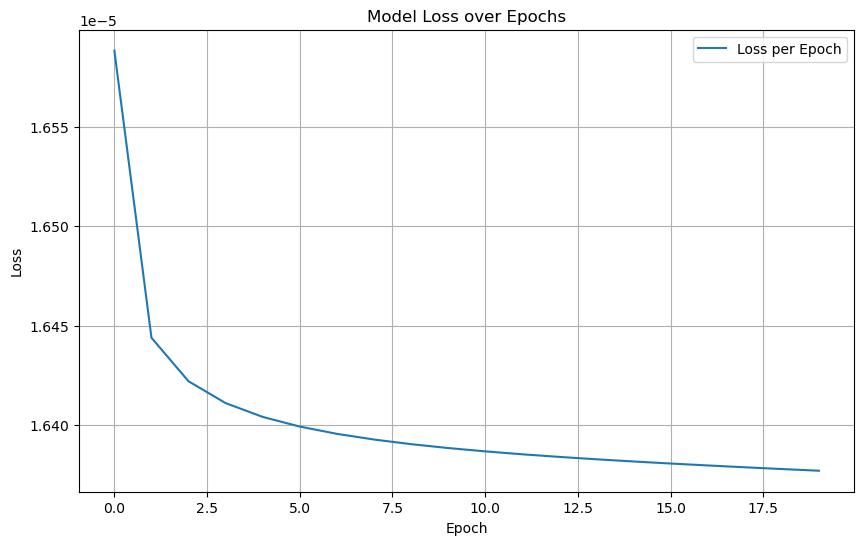

In [232]:
plot_training_loss(loss_list)

## Model Testing 

In [233]:
train_acc, test_acc = test(W, b, X_train, y_train, valid_train, X_test, y_test, valid_test)

Training Accuracy: 0.7241593395344205
Testing Accuracy: 0.7325025868604091


## Saving Model Architecture

In [234]:
pickle_filename = 'Results/Model1/model1_optimal.pkl'

In [235]:
# model1_optimal = {
#     "weights": W,
#     "bias": b,
#     "loss_list": loss_list,
#     "train_acc": train_acc,
#     "test_acc": test_acc
# }

In [236]:
# with open(pickle_filename, 'wb') as file:
#     pickle.dump(model1_optimal, file)

## Loading Model Architecture

In [237]:
# model1_optimal = {}

In [238]:
# with open(pickle_filename, 'rb') as file:
#     model1_optimal = pickle.load(file)

In [239]:
# W = model1_optimal["weights"]
# b = model1_optimal["bias"]

In [240]:
# W, b

## Simulation Testing Setup

In [241]:
def predict_to_move(bot, prediction):
    next_move = bot
    
    if np.array_equal(prediction, np.array([[1, 0, 0, 0, 0]])):
        next_move = (bot[0], bot[1] + 1)
    elif np.array_equal(prediction, np.array([[0, 1, 0, 0, 0]])):
        next_move = (bot[0], bot[1] - 1)
    elif np.array_equal(prediction, np.array([[0, 0, 1, 0, 0]])):
        next_move = (bot[0] - 1, bot[1])
    elif np.array_equal(prediction, np.array([[0, 0, 0, 1, 0]])):
        next_move = (bot[0] + 1, bot[1])
    else:
        next_move = bot
        
    return next_move

In [255]:
def predict_with_params(bot, alien_matrix, crew_matrix, alien_detected, crew_detected):
    alien_probs = determine_probabilities(bot, alien_matrix)
    crew_probs = determine_probabilities(bot, crew_matrix)
    
    X = pd.DataFrame([{
        'bot_x': bot[0],
        'bot_y': bot[1],

        'alien_up': alien_probs[0],
        'alien_down': alien_probs[1],
        'alien_left': alien_probs[2],
        'alien_right': alien_probs[3],
        'alien_stay': alien_probs[4],

        'crew_up': crew_probs[0],
        'crew_down': crew_probs[1],
        'crew_left': crew_probs[2],
        'crew_right': crew_probs[3],
#         'crew_stay': crew_probs[4],

        'alien_detected': 1 if alien_detected else 0,
        'crew_detected': 1 if crew_detected else 0,
    }], columns=['bot_x', 'bot_y', 'alien_up', 'alien_down', 'alien_left', 'alien_right', 'alien_stay', 'crew_up', 'crew_down', 'crew_left', 'crew_right', 'alien_detected', 'crew_detected'])
    
    valid = create_valid_matrix(X)
    
    crew_columns = ['crew_up', 'crew_down', 'crew_left', 'crew_right']
    X['sum_crew'] = X[crew_columns].sum(axis=1)

    for col in crew_columns:
        X.loc[X['sum_crew'] != 0, col] = X[col] / X['sum_crew']

    X.drop('sum_crew', axis=1, inplace=True)
    
    prediction = predict_constrained(X, W, b, valid)
    next_move = predict_to_move(bot, prediction)
    
    return next_move

## Bot1 vs. Mimic-Bot1

In [256]:
def Bot1(k, alpha, max_iter, timeout):
    global grid, open_cells
    
    grid, open_cells = reset_grid(grid, open_cells)
    bot, ship, open_cells = place_bot(grid, open_cells)

    crew_list = []
    alien_list = []
    d_lookup_table = {}

    crew_list, ship = place_crew(ship, open_cells, crew_list)
    alien_list, ship = place_alien(ship, open_cells, alien_list, bot, k)

    alien_matrix = initialize_alienmatrix(open_cells, bot, k)
    crew_matrix = initialize_crewmatrix(open_cells, crew_list, bot)

    win_count = 0
    loss_count = 0
    move = 0
    win_move_count = []
    marker = 0
    
    while (win_count + loss_count) < max_iter:
        neighbors = check_valid_neighbors(len(ship), bot[0], bot[1])
        open_moves = [neigh for neigh in neighbors if (grid[neigh] != 1)]
        open_moves.append(bot)
        next_move = determine_move(open_moves, alien_matrix, crew_matrix) # Determine move deterministically as in Project 2
        
        prev_win_count = win_count
        bot, crew_list, ship, open_cells, win_count, marker = move_bot(ship, bot, next_move, crew_list, alien_list, open_cells, win_count, 1)
        move += 1

        if marker == 1 or move >= timeout:
            loss_count += 1
            print(f"Bot1 captured! Win Count: {win_count}, Loss Count: {loss_count}")

            grid, open_cells = reset_grid(grid, open_cells)
            bot, ship, open_cells = place_bot(grid, open_cells)
            crew_list = []
            alien_list = []
            d_lookup_table = {}

            crew_list, ship = place_crew(ship, open_cells, crew_list)
            alien_list, ship = place_alien(ship, open_cells, alien_list, bot, k)

            alien_matrix = initialize_alienmatrix(open_cells, bot, k)
            crew_matrix = initialize_crewmatrix(open_cells, crew_list, bot)
            marker = 0
            move = 0

            continue

        if win_count > prev_win_count:
            print(f"Crew saved! Win Count: {win_count}, Loss Count: {loss_count}")
            win_move_count.append(move)
            move = 0
            d_lookup_table = {}
            alien_matrix = initialize_alienmatrix(open_cells, bot, k)
            crew_matrix = initialize_crewmatrix(open_cells, crew_list, bot)
        
        print(f"Bot1: {bot}, Crew: {crew_list}, Aliens: {alien_list}")

        alien_matrix, crew_matrix = update_afterbotmove(bot, alien_matrix, crew_matrix)

        # Move bot to optimal neighbor
        marker, alien_list, ship = move_aliens(ship, alien_list, bot) # Move alien randomly

        if marker == 1 or move >= timeout:
            loss_count += 1
            print(f"Bot1 captured! Win Count: {win_count}, Loss Count: {loss_count}")

            grid, open_cells = reset_grid(grid, open_cells)
            bot, ship, open_cells = place_bot(grid, open_cells)
            crew_list = []
            alien_list = []
            d_lookup_table = {}

            crew_list, ship = place_crew(ship, open_cells, crew_list)
            alien_list, ship = place_alien(ship, open_cells, alien_list, bot, k)

            alien_matrix = initialize_alienmatrix(open_cells, bot, k)
            crew_matrix = initialize_crewmatrix(open_cells, crew_list, bot)
            marker = 0
            move = 0

            continue
        
        alien_matrix = update_afteralienmove(ship, alien_list, alien_matrix) # Update after alien move
        
        alien_detected = alien_sensor(alien_list, bot, k) # Run Alien Sensor
        crew_detected, d_lookup_table = crew_sensor(ship, bot, alpha, d_lookup_table, crew_list) # Run Crew Sensor
        
        alien_matrix = update_alienmatrix(alien_matrix, alien_detected, bot, k) # Update based on alien sensor

        crew_matrix = update_crewmatrix(crew_matrix, crew_detected, d_lookup_table, bot, alpha) # Update based on crew sensor

    return sum(win_move_count) // max(1, len(win_move_count)), (win_count / max(1, (win_count + loss_count))), win_count

In [257]:
def Mimic_Bot1(k, alpha, max_iter, timeout):
    global grid, open_cells
    
    grid, open_cells = reset_grid(grid, open_cells)
    bot, ship, open_cells = place_bot(grid, open_cells)

    crew_list = []
    alien_list = []
    d_lookup_table = {}

    crew_list, ship = place_crew(ship, open_cells, crew_list)
    alien_list, ship = place_alien(ship, open_cells, alien_list, bot, k)

    alien_matrix = initialize_alienmatrix(open_cells, bot, k)
    crew_matrix = initialize_crewmatrix(open_cells, crew_list, bot)
    
    alien_detected = False
    crew_detected = False

    win_count = 0
    loss_count = 0
    move = 0
    win_move_count = []
    marker = 0
    
    while (win_count + loss_count) < max_iter:
        neighbors = check_valid_neighbors(len(ship), bot[0], bot[1])
        open_moves = [neigh for neigh in neighbors if (grid[neigh] != 1)]
        open_moves.append(bot)
        next_move = predict_with_params(bot, alien_matrix, crew_matrix, alien_detected, crew_detected) # Predict using optimal W, b for Model 1
        
        prev_win_count = win_count
        bot, crew_list, ship, open_cells, win_count, marker = move_bot(ship, bot, next_move, crew_list, alien_list, open_cells, win_count, 1)
        move += 1

        if marker == 1 or move >= timeout:
            loss_count += 1
            print(f"Mimic-Bot1 captured! Win Count: {win_count}, Loss Count: {loss_count}")

            grid, open_cells = reset_grid(grid, open_cells)
            bot, ship, open_cells = place_bot(grid, open_cells)
            crew_list = []
            alien_list = []
            d_lookup_table = {}

            crew_list, ship = place_crew(ship, open_cells, crew_list)
            alien_list, ship = place_alien(ship, open_cells, alien_list, bot, k)

            alien_matrix = initialize_alienmatrix(open_cells, bot, k)
            crew_matrix = initialize_crewmatrix(open_cells, crew_list, bot)
            marker = 0
            move = 0

            continue

        if win_count > prev_win_count:
            print(f"Crew saved! Win Count: {win_count}, Loss Count: {loss_count}")
            win_move_count.append(move)
            move = 0
            d_lookup_table = {}
            alien_matrix = initialize_alienmatrix(open_cells, bot, k)
            crew_matrix = initialize_crewmatrix(open_cells, crew_list, bot)
        
        print(f"Mimic-Bot1: {bot}, Crew: {crew_list}, Aliens: {alien_list}")

        alien_matrix, crew_matrix = update_afterbotmove(bot, alien_matrix, crew_matrix)

        # Move bot to optimal neighbor
        marker, alien_list, ship = move_aliens(ship, alien_list, bot) # Move alien randomly

        if marker == 1 or move >= timeout:
            loss_count += 1
            print(f"Mimic-Bot1 captured! Win Count: {win_count}, Loss Count: {loss_count}")

            grid, open_cells = reset_grid(grid, open_cells)
            bot, ship, open_cells = place_bot(grid, open_cells)
            crew_list = []
            alien_list = []
            d_lookup_table = {}

            crew_list, ship = place_crew(ship, open_cells, crew_list)
            alien_list, ship = place_alien(ship, open_cells, alien_list, bot, k)

            alien_matrix = initialize_alienmatrix(open_cells, bot, k)
            crew_matrix = initialize_crewmatrix(open_cells, crew_list, bot)
            marker = 0
            move = 0

            continue
        
        alien_matrix = update_afteralienmove(ship, alien_list, alien_matrix) # Update after alien move
        
        alien_detected = alien_sensor(alien_list, bot, k) # Run Alien Sensor
        crew_detected, d_lookup_table = crew_sensor(ship, bot, alpha, d_lookup_table, crew_list) # Run Crew Sensor
        
        alien_matrix = update_alienmatrix(alien_matrix, alien_detected, bot, k) # Update based on alien sensor

        crew_matrix = update_crewmatrix(crew_matrix, crew_detected, d_lookup_table, bot, alpha) # Update based on crew sensor

    return sum(win_move_count) // max(1, len(win_move_count)), (win_count / max(1, (win_count + loss_count))), win_count

In [258]:
def Bot1_vs_MimicBot1(alpha_values, k_values, max_iter, timeout, num_simulations):
    avg_rescue_moves_bot1 = {k: [] for k in k_values}
    prob_crew_rescue_bot1 = {k: [] for k in k_values}
    avg_crew_saved_bot1 = {k: [] for k in k_values}
    
    avg_rescue_moves_mbot1 = {k: [] for k in k_values}
    prob_crew_rescue_mbot1 = {k: [] for k in k_values}
    avg_crew_saved_mbot1 = {k: [] for k in k_values}

    for k in k_values:
        for alpha in alpha_values:
            total_metric1_bot1, total_metric2_bot1, total_metric3_bot1 = 0, 0, 0
            total_metric1_mbot1, total_metric2_mbot1, total_metric3_mbot1 = 0, 0, 0
            
            for i in range(num_simulations):
                metric1_bot1, metric2_bot1, metric3_bot1 = Mimic_Bot1(k, alpha, max_iter, timeout)
                metric1_mbot1, metric2_mbot1, metric3_mbot1 = Mimic_Bot1(k, alpha, max_iter, timeout)
                
                total_metric1_bot1 += metric1_bot1
                total_metric2_bot1 += metric2_bot1
                total_metric3_bot1 += metric3_bot1
                
                total_metric1_mbot1 += metric1_mbot1
                total_metric2_mbot1 += metric2_mbot1
                total_metric3_mbot1 += metric3_mbot1

            avg_metric1_bot1 = total_metric1_bot1 / num_simulations
            avg_metric2_bot1 = total_metric2_bot1 / num_simulations
            avg_metric3_bot1 = total_metric3_bot1 / num_simulations
            
            avg_metric1_mbot1 = total_metric1_mbot1 / num_simulations
            avg_metric2_mbot1 = total_metric2_mbot1 / num_simulations
            avg_metric3_mbot1 = total_metric3_mbot1 / num_simulations

            print(f"Bot1: k={k}, Alpha={alpha}\nAverage Rescue Moves={avg_metric1_bot1}\nProbability of Crew Rescue={avg_metric2_bot1}\nAverage Crew Saved={avg_metric3_bot1}\n")
            print(f"Mimic-Bot1: k={k}, Alpha={alpha}\nAverage Rescue Moves={avg_metric1_mbot1}\nProbability of Crew Rescue={avg_metric2_mbot1}\nAverage Crew Saved={avg_metric3_mbot1}\n")

            avg_rescue_moves_bot1[k].append(avg_metric1_bot1)
            prob_crew_rescue_bot1[k].append(avg_metric2_bot1)
            avg_crew_saved_bot1[k].append(avg_metric3_bot1)
            
            avg_rescue_moves_mbot1[k].append(avg_metric1_mbot1)
            prob_crew_rescue_mbot1[k].append(avg_metric2_mbot1)
            avg_crew_saved_mbot1[k].append(avg_metric3_mbot1)

    return avg_rescue_moves_bot1, prob_crew_rescue_bot1, avg_crew_saved_bot1, avg_rescue_moves_mbot1, prob_crew_rescue_mbot1, avg_crew_saved_mbot1

In [259]:
def test_simulation_model1(alpha_values, k_values, max_iter, timeout, num_simulations):
    avg_rescue_moves_bot1, prob_crew_rescue_bot1, avg_crew_saved_bot1, avg_rescue_moves_mbot1, prob_crew_rescue_mbot1, avg_crew_saved_mbot1 = Bot1_vs_MimicBot1(alpha_values, k_values, max_iter, timeout, num_simulations)

    prob_crew_rescue_bot1 = {k: [round(prob, 3) for prob in probs] for k, probs in prob_crew_rescue_bot1.items()}
    prob_crew_rescue_mbot1 = {k: [round(prob, 3) for prob in probs] for k, probs in prob_crew_rescue_mbot1.items()}

    print(f"Bot1:\nAverage Rescue Moves = {avg_rescue_moves_bot1}\nProbability of Crew Rescue = {prob_crew_rescue_bot1}\nAverage Crew Saved = {avg_crew_saved_bot1}\n\n")
    print(f"Mimic-Bot1:\nAverage Rescue Moves = {avg_rescue_moves_mbot1}\nProbability of Crew Rescue = {prob_crew_rescue_mbot1}\nAverage Crew Saved = {avg_crew_saved_mbot1}\n")
    
    return avg_rescue_moves_bot1, prob_crew_rescue_bot1, avg_crew_saved_bot1, avg_rescue_moves_mbot1, prob_crew_rescue_mbot1, avg_crew_saved_mbot1

In [260]:
alpha_values = [0.004]
k_values = [3]
max_iter = 30
timeout = 10000
num_simulations = 20

In [261]:
metric1_bot1, metric2_bot1, metric3_bot1, metric1_mbot1, metric2_mbot1, metric3_mbot1 = test_simulation_model1(alpha_values, k_values, max_iter, timeout, num_simulations)

Mimic-Bot1: (1, 3), Crew: [(1, 22)], Aliens: [(20, 15)]
Mimic-Bot1: (0, 3), Crew: [(1, 22)], Aliens: [(19, 15)]
Mimic-Bot1: (0, 4), Crew: [(1, 22)], Aliens: [(19, 16)]
Mimic-Bot1: (0, 5), Crew: [(1, 22)], Aliens: [(19, 16)]
Mimic-Bot1: (0, 6), Crew: [(1, 22)], Aliens: [(20, 16)]
Mimic-Bot1: (0, 7), Crew: [(1, 22)], Aliens: [(20, 17)]
Mimic-Bot1: (0, 8), Crew: [(1, 22)], Aliens: [(19, 17)]
Mimic-Bot1: (0, 9), Crew: [(1, 22)], Aliens: [(19, 16)]
Mimic-Bot1: (1, 9), Crew: [(1, 22)], Aliens: [(20, 16)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(20, 16)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(20, 16)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(19, 16)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(19, 16)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(19, 16)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(19, 15)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(19, 16)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(19, 17)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Al

Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(26, 21)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(26, 21)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(27, 21)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(26, 21)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(25, 21)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(25, 21)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(25, 21)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(25, 22)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(25, 23)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(25, 23)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(25, 23)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(25, 23)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(26, 23)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(26, 22)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(26, 23)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(26, 23)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(26, 23)]
Mimic-Bot1: (1, 10), Crew: [(1,

Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(25, 23)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(26, 23)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(26, 22)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(26, 22)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(26, 23)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(27, 23)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(27, 23)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(26, 23)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(26, 22)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(26, 23)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(26, 23)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(27, 23)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(27, 23)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(27, 23)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(27, 23)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(27, 24)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(27, 23)]
Mimic-Bot1: (2, 10), Crew: [(1,

Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(22, 20)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(22, 21)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(22, 20)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(22, 21)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(22, 22)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(22, 22)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(23, 22)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(23, 22)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(24, 22)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(23, 22)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(24, 22)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(25, 22)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(25, 21)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(25, 20)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(25, 21)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(24, 21)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(24, 20)]
Mimic-Bot1: (1, 10), Crew: [(1,

Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(28, 19)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(28, 20)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(27, 20)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(27, 20)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(27, 20)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(27, 19)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(28, 19)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(28, 19)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(29, 19)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(28, 19)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(28, 19)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(28, 20)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(28, 20)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(27, 20)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(27, 19)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(27, 19)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(27, 18)]
Mimic-Bot1: (1, 10), Crew: [(1,

Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(18, 13)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(18, 13)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(17, 13)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(18, 13)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(17, 13)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(18, 13)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(17, 13)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(18, 13)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(18, 14)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(18, 13)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(18, 13)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(17, 13)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(17, 14)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(17, 13)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(17, 14)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(18, 14)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(18, 13)]
Mimic-Bot1: (2, 10), Crew: [(1,

Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(6, 11)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(6, 12)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(6, 11)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(6, 12)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(6, 13)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(6, 12)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(6, 13)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(5, 13)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(5, 13)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(6, 13)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(6, 13)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(6, 12)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(6, 13)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(6, 12)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(6, 13)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(6, 12)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(6, 13)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(

Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(13, 13)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(12, 13)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(12, 12)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(11, 12)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(11, 11)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(11, 12)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(11, 13)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(12, 13)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(12, 14)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(13, 14)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(13, 15)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(13, 15)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(13, 14)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(13, 13)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(12, 13)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(11, 13)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(10, 13)]
Mimic-Bot1: (2, 10), Crew: [(1,

Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(20, 12)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(21, 12)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(21, 11)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(20, 11)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(20, 12)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(20, 13)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(20, 12)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(21, 12)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(21, 12)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(22, 12)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(22, 11)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(22, 11)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(22, 10)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(22, 11)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(22, 11)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(22, 11)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(22, 12)]
Mimic-Bot1: (2, 10), Crew: [(1,

Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(27, 19)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(26, 19)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(27, 19)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(27, 19)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(28, 19)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(29, 19)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(29, 19)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(29, 19)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(28, 19)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(29, 19)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(29, 19)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(29, 19)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(29, 19)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(29, 18)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(29, 18)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(29, 19)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(29, 19)]
Mimic-Bot1: (1, 10), Crew: [(1,

Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(27, 8)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(27, 7)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(27, 7)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(26, 7)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(27, 7)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(27, 7)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(27, 8)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(27, 7)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(27, 8)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(27, 9)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(27, 9)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(27, 9)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(27, 8)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(27, 8)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(27, 8)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(27, 8)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(27, 7)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(

Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(29, 10)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(29, 9)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(29, 9)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(29, 8)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(29, 7)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(29, 6)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(29, 7)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(29, 6)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(28, 6)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(28, 5)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(28, 4)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(28, 5)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(29, 5)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(28, 5)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(29, 5)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(28, 5)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(27, 5)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [

Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(25, 0)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(26, 0)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(25, 0)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(25, 0)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(26, 0)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(26, 0)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(26, 0)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(26, 0)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(26, 0)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(25, 0)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(25, 0)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(24, 0)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(24, 0)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(24, 1)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(24, 1)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(23, 1)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(24, 1)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(

Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(14, 4)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(14, 4)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(14, 3)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(14, 3)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(14, 4)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(14, 4)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(14, 5)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(14, 5)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(14, 6)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(14, 6)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(13, 6)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(12, 6)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(13, 6)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(12, 6)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(11, 6)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(10, 6)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(10, 5)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(

Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(15, 3)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(16, 3)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(16, 3)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(15, 3)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(15, 2)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(15, 3)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(15, 3)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(15, 3)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(15, 2)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(15, 1)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(15, 1)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(15, 2)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(15, 3)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(15, 2)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(15, 3)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(15, 2)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(15, 2)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(

Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(8, 13)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(8, 14)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(8, 14)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(8, 13)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(8, 12)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(8, 13)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(8, 14)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(8, 15)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(8, 15)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(8, 14)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(8, 13)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(8, 12)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(7, 12)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(6, 12)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(7, 12)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(6, 12)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(6, 13)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(

Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(17, 12)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(17, 11)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(17, 12)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(17, 11)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(18, 11)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(17, 11)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(17, 11)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(17, 12)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(17, 12)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(16, 12)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(16, 12)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(16, 12)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(16, 12)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(15, 12)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(15, 12)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(15, 13)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(15, 14)]
Mimic-Bot1: (1, 10), Crew: [(1,

Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(18, 24)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(18, 24)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(18, 24)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(18, 24)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(17, 24)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(16, 24)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(16, 24)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(17, 24)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(17, 24)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(17, 23)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(17, 24)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(17, 23)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(18, 23)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(19, 23)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(18, 23)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(18, 24)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(18, 24)]
Mimic-Bot1: (2, 10), Crew: [(1,

Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(15, 17)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(15, 16)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(15, 17)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(14, 17)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(13, 17)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(14, 17)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(14, 17)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(15, 17)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(14, 17)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(13, 17)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(13, 18)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(13, 19)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(12, 19)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(13, 19)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(13, 20)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(14, 20)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(13, 20)]
Mimic-Bot1: (1, 10), Crew: [(1,

Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(5, 28)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(6, 28)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(5, 28)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(6, 28)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(7, 28)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(7, 28)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(7, 28)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(8, 28)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(7, 28)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(7, 29)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(7, 28)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(7, 27)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(7, 27)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(7, 28)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(7, 28)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(7, 27)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(7, 27)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(

Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(10, 22)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(9, 22)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(8, 22)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(7, 22)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(6, 22)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(6, 22)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(7, 22)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(8, 22)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(7, 22)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(6, 22)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(6, 22)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(7, 22)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(8, 22)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(7, 22)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(6, 22)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(6, 23)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(6, 24)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [

Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(9, 17)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(9, 16)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(10, 16)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(9, 16)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(9, 17)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(9, 16)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(10, 16)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(10, 15)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(11, 15)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(10, 15)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(11, 15)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(10, 15)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(10, 15)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(10, 16)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(9, 16)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(9, 16)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(9, 16)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], A

Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(10, 18)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(10, 19)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(10, 18)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(11, 18)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(11, 18)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(10, 18)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(10, 19)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(10, 19)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(10, 18)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(10, 18)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(10, 18)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(11, 18)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(10, 18)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(9, 18)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(9, 17)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(9, 16)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(10, 16)]
Mimic-Bot1: (2, 10), Crew: [(1, 22

Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(13, 18)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(13, 18)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(13, 18)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(13, 17)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(14, 17)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(14, 17)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(15, 17)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(15, 16)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(16, 16)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(16, 16)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(17, 16)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(17, 17)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(17, 16)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(17, 16)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(16, 16)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(16, 16)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(17, 16)]
Mimic-Bot1: (1, 10), Crew: [(1,

Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(14, 28)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(14, 28)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(13, 28)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(13, 27)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(14, 27)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(14, 28)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(14, 28)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(15, 28)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(15, 29)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(15, 29)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(15, 28)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(14, 28)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(15, 28)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(14, 28)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(14, 28)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(15, 28)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(14, 28)]
Mimic-Bot1: (1, 10), Crew: [(1,

Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(7, 18)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(7, 17)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(7, 17)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(7, 17)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(8, 17)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(7, 17)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(7, 17)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(7, 17)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(7, 18)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(7, 17)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(6, 17)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(6, 17)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(5, 17)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(5, 17)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(6, 17)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(7, 17)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(6, 17)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(

Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(10, 9)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(9, 9)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(8, 9)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(8, 9)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(7, 9)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(6, 9)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(6, 10)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(5, 10)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(6, 10)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(7, 10)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(7, 9)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(8, 9)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(7, 9)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(8, 9)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(8, 8)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(8, 9)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(9, 9)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(8, 9)]
Mimic

Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(11, 13)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(11, 12)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(11, 11)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(11, 11)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(11, 11)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(10, 11)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(11, 11)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(10, 11)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(9, 11)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(9, 11)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(9, 11)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(9, 10)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(9, 9)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(10, 9)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(10, 9)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(9, 9)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(9, 9)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Alien

Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(15, 10)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(15, 9)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(15, 10)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(15, 9)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(15, 8)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(15, 8)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(15, 8)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(16, 8)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(16, 7)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(17, 7)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(16, 7)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(16, 7)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(16, 7)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(16, 8)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(16, 7)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: [(16, 7)]
Mimic-Bot1: (1, 10), Crew: [(1, 22)], Aliens: [(17, 7)]
Mimic-Bot1: (2, 10), Crew: [(1, 22)], Aliens: 

KeyboardInterrupt: 

## Obsolete

In [ ]:
# def Bot1(k, alpha, max_iter, timeout):
#     global grid, open_cells
#     bot, ship, open_cells = place_bot(grid, open_cells)

#     crew_list = []
#     alien_list = []
#     d_lookup_table = {}

#     crew_list, ship = place_crew(ship, open_cells, crew_list)
#     alien_list, ship = place_alien(ship, open_cells, alien_list, bot, k)

#     alien_matrix = initialize_alienmatrix(open_cells, bot, k)
#     crew_matrix = initialize_crewmatrix(open_cells, crew_list, bot)

#     win_count = 0
#     loss_count = 0
#     move = 0
#     win_move_count = []
#     marker = 0

#     while (win_count + loss_count) < max_iter:
#         neighbors = check_valid_neighbors(len(ship), bot[0], bot[1])
#         open_moves = [neigh for neigh in neighbors if (grid[neigh] != 1)]
#         open_moves.append(bot) # Bot can stay in place 
#         next_move = determine_move(open_moves, alien_matrix, crew_matrix)
        
#         prev_win_count = win_count
#         bot, crew_list, ship, open_cells, win_count, marker = move_bot(ship, bot, next_move, crew_list, alien_list, open_cells, win_count, 1)
#         move += 1

#         if marker == 1 or move >= timeout:
#             loss_count += 1
#             print(f"Bot captured! Win Count: {win_count}, Loss Count: {loss_count}")

#             grid, open_cells = reset_grid(grid, open_cells)
#             bot, ship, open_cells = place_bot(grid, open_cells)
#             crew_list = []
#             alien_list = []
#             d_lookup_table = {}

#             crew_list, ship = place_crew(ship, open_cells, crew_list)
#             alien_list, ship = place_alien(ship, open_cells, alien_list, bot, k)

#             alien_matrix = initialize_alienmatrix(open_cells, bot, k)
#             crew_matrix = initialize_crewmatrix(open_cells, crew_list, bot)
#             marker = 0
#             move = 0

#             continue

#         if win_count > prev_win_count:
#             print(f"Crew saved! Win Count: {win_count}, Loss Count: {loss_count}")
#             win_move_count.append(move)
#             move = 0
#             d_lookup_table = {}
#             alien_matrix = initialize_alienmatrix(open_cells, bot, k)
#             crew_matrix = initialize_crewmatrix(open_cells, crew_list, bot)
        
#         print(f"Bot: {bot}, Crew: {crew_list}, Aliens: {alien_list}")

#         alien_matrix, crew_matrix = update_afterbotmove(bot, alien_matrix, crew_matrix)

#         # Move bot to optimal neighbor
#         marker, alien_list, ship = move_aliens(ship, alien_list, bot) # Move alien randomly

#         if marker == 1 or move >= timeout:
#             loss_count += 1
#             print(f"Bot captured! Win Count: {win_count}, Loss Count: {loss_count}")

#             grid, open_cells = reset_grid(grid, open_cells)
#             bot, ship, open_cells = place_bot(grid, open_cells)
#             crew_list = []
#             alien_list = []
#             d_lookup_table = {}

#             crew_list, ship = place_crew(ship, open_cells, crew_list)
#             alien_list, ship = place_alien(ship, open_cells, alien_list, bot, k)

#             alien_matrix = initialize_alienmatrix(open_cells, bot, k)
#             crew_matrix = initialize_crewmatrix(open_cells, crew_list, bot)
#             marker = 0
#             move = 0

#             continue
        
#         alien_matrix = update_afteralienmove(ship, alien_list, alien_matrix) # Update after alien move
        
#         alien_detected = alien_sensor(alien_list, bot, k) # Run Alien Sensor
#         crew_detected, d_lookup_table = crew_sensor(ship, bot, alpha, d_lookup_table, crew_list) # Run Crew Sensor
        
#         alien_matrix = update_alienmatrix(alien_matrix, alien_detected, bot, k) # Update based on alien sensor

#         crew_matrix = update_crewmatrix(crew_matrix, crew_detected, d_lookup_table, bot, alpha) # Update based on crew sensor

#     return sum(win_move_count) // max(1, len(win_move_count)), (win_count / max(1, (win_count + loss_count))), win_count

In [ ]:
# def plot_Bot1(alpha_values, k_values, bot1_data, title, metric_num):
#     # Generate a plot for each k-value
#     for k in k_values:
#         plt.figure(figsize=(10, 6))
#         plt.plot(alpha_values, bot1_data[k], label=f'Bot 1, k={k}')
#         plt.title(f'{title} (k={k})')
#         plt.xlabel('alpha')
#         plt.ylabel(title)

#         # Set x-axis ticks
#         plt.xticks(alpha_values, labels=[str(alpha) for alpha in alpha_values])

#         plt.legend()
#         plt.grid(True)
        
#         plt.show()

In [ ]:
# def one_alien_one_crew(alpha_values, k_values, max_iter, timeout, num_simulations):
#     bot1_avg_rescue_moves, bot1_prob_crew_rescue, bot1_avg_crew_saved = Bot1_simulation(alpha_values, k_values, max_iter, timeout, num_simulations)

#     bot1_prob_crew_rescue = {k: [round(prob, 3) for prob in probs] for k, probs in bot1_prob_crew_rescue.items()}

#     print(bot1_avg_rescue_moves, bot1_prob_crew_rescue, bot1_avg_crew_saved, "\n")

#     plot_Bot1(alpha_values, k_values, bot1_avg_rescue_moves, 'Average Rescue Moves', 1)
#     plot_Bot1(alpha_values, k_values, bot1_prob_crew_rescue, 'Probability of Crew Rescue', 2)
#     plot_Bot1(alpha_values, k_values, bot1_avg_crew_saved, 'Average Crew Saved', 3)

In [ ]:
# # Train Function that uses SGD and GD
# def train(X, y, valid, alpha, epochs, initial_batch_size, loss_threshold):
#     num_features = X.shape[1]
#     num_classes = 5
#     n = X.shape[0]

#     W, b = init_params(num_features, num_classes)
# #     print(W, b)

#     previous_loss = float('inf')  # Set starting loss to infinity
#     batch_size = initial_batch_size  # Start with SGD (smaller batch size)
#     switched_to_gd = False
#     loss_list = []  # Store loss values over time
    
#     # Number of times iterated through entire dataset
#     for epoch in range(epochs):
#         current_loss = 0
        
#         # Only iterate over batch size. In SGD, batch size is small, so iterate over smaller batches and update loss
#         for i in range(0, n, batch_size):
#             X_batch = X.iloc[i:i + batch_size]
#             y_batch = y.iloc[i:i + batch_size]
#             valid_batch = valid[i:i + batch_size]

#             y_pred = predict(X_batch, W, b)
# #             print(y_batch, y_pred, valid_batch)
#             batch_loss = loss_function(y_batch, y_pred, valid_batch)
#             current_loss += batch_loss

#             dW, db = compute_gradient(X_batch, y_batch, y_pred, valid_batch)
#             W -= alpha * dW
#             b -= alpha * db

#         current_loss /= (n // batch_size)
#         loss_list.append(current_loss)

#         # Check if loss threshold is met to switch to GD
#         if not switched_to_gd and abs(previous_loss - current_loss) < loss_threshold:
#             batch_size = n  # Set batch size to full dataset (switch to Gradient Descent)
#             switched_to_gd = True
#             print(f"Switched to Gradient Descent. Epoch: {epoch}")

#         previous_loss = current_loss
        
#         print(f"Epoch {epoch}, Loss: {current_loss}")

#     return W, b, loss_list